In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
from scipy.io import wavfile
from IPython.display import Audio

The TRUE wave equation (with damping and stress-strain coupling):
$$\frac{\partial^2 y}{\partial x^2} - \frac{1}{c^2}\frac{\partial^2y}{\partial t^2} - \gamma \frac{\partial y}{\partial t} - l^2 \frac{\partial^4 y}{\partial x^4} = 0$$
$$y(0, t) = y(L, t) = 0$$
$$y(x, 0) = f(x)$$

$y$ is  the amplitude of the string, $x$ is the location of the string and $t$ is the time.

Parameters:
- $c$: speed of the wave $[m/s]$
- $\gamma$: speed of the wave $[s/m]$
- $l$: characteristic length (stiffness term) [dimensionless]

Notation: $y^t_x$ $=$ amplitude of string at time $t$ and position $x$

Discrete form:
$$\frac{y^m_{j+1} - 2y^m_j + y^m_{j-1}}{\Delta x^2} - \frac{1}{c^2}\frac{y^{m+1}_j - 2y^m_j + y^{m-1}_j}{\Delta t^2} -  \gamma \frac{y^{m+1}_j - y^{m-1}_j}{\Delta t} - l^2 \frac{y^m_{j+2} - 4y^m_{j+1} + 4y^m_j - 4y^m_{j-1} - y^m_{j-2}}{\Delta x^2} = 0$$ 

Solve for $y^{m+1}_j$ (the amplitude of the string at the next time):
$$y^{m+1}_j = \Big[\frac{1}{c^2\Delta t^2} + \frac{\gamma}{2\Delta t}\Big]^{-1}\Big[\frac{y^m_{j+1} - 2y^m_j + y^m_{j-1}}{\Delta x^2} - \frac{1}{c^2}\frac{y^{m+1}_j - 2y^m_j + y^{m-1}_j}{\Delta t^2} + \frac{\gamma}{2\Delta}y^{m-1}_j - l^2 \frac{y^m_{j+2} - 4y^m_{j+1} + 4y^m_j - 4y^m_{j-1} - y^m_{j-2}}{\Delta x^4} \Big]$$

In order for this to be stable, need $c\frac{\Delta t}{\Delta x} < 1$ (Courant - Friedrichs - Levy Criterion)

# Solving

Guitar string length = $\boxed {L = \text{0.7 m}}$

Choose $\boxed{N_x = \text{101}}$ guitar string positions $\implies$ $\boxed{\Delta x = \text{0.7 m}}$

Note that the fundamental frequency of a guitar note is $f = c/2L$. With "A note" at 220Hz get $\boxed {c = \text{308 m/s}}$

To obey our constraint we thus set $\boxed{\Delta t = \text{5} \times 10^{-6} s}$. In order to get multiple seconds of a result, choose $\boxed{N_t = \text{500000}}$

Two parameters that seemed to give a solution that sounded like a string were $\boxed{l = \text{2} \times 10^{-6}}$ and $\boxed{\gamma = \text{2.6} \times 10^{-5} s/m}$

Defining constants

In [2]:
Nx = 101
Nt = 500000
L = 0.7
dx = L/(Nx - 1)
f = 220
c = 2*L*f
dt = 5e-6
l = 2e-6
gamma = 2.6e-5

Initial state of the string

In [3]:
ya = np.linspace(0, 0.01, 70)
yb = np.linspace(0.01, 0, 31)
y0 = np.concatenate([ya, yb])

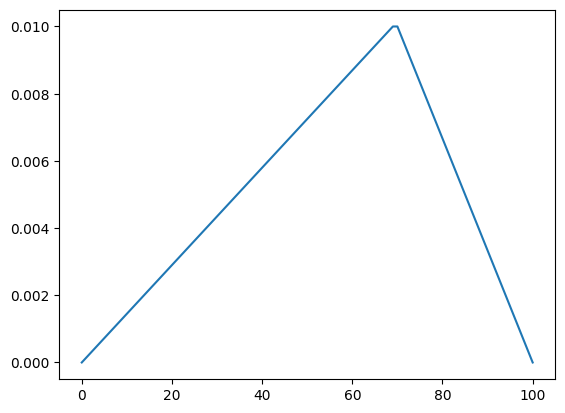

In [4]:
plt.plot(y0) # not to scale

Create 2D array of $y(x, t)$

In [5]:
sol = np.zeros((Nt, Nx))

Make the solution at $t = 0$ and $t = 1$ equal to the "pluck"

In [6]:
sol[0] = y0
sol[1] = y0

Go through the iterative procedure

In [7]:
# f8 = float64 (double)
# f8[:,:] = 2d array of float64
# i8 = int64 (64-bit integer)
# "${return-type}(${parameter-1}...)"
# https://numba.readthedocs.io/en/stable/user/jit.html#nopython
# https://numba.readthedocs.io/en/stable/user/jit.html#nogil

@numba.jit("f8[:,:](f8[:,:], i8, i8, f8, f8, f8, f8)", nopython=True, nogil=True)
def compute_d(d, times, length, dt, dx, l, gamma):
    '''
    This function essentially computes the equation for y_j^{m+1}
    '''
    for t in range(1, times - 1):
        for i in range(2, length-2):
            outer_fact = (1/(c**2 * dt**2) + gamma/(2*dt))**(-1)
            p1 = 1/dx**2 * (d[t][i-1] - 2*d[t][i] + d[t][i+1])
            p2 = 1/(c**2 * dt**2) * (d[t-1][i] - 2*d[t][i])
            p3 = gamma/(2*dt) * d[t-1][i]
            p4 = l**2/dx**4 * (d[t][i+2] - 4*d[t][i+1] + 6*d[t][i] - 4*d[t][i-1] + d[t][i-2])
            d[t+1][i] = outer_fact * (p1 - p2 + p3 - p4)
    return d

In [8]:
sol = compute_d(sol, Nt, Nx, dt, dx, l, gamma)
sol

array([[0.00000000e+00, 1.44927536e-04, 2.89855072e-04, ...,
        6.66666667e-04, 3.33333333e-04, 0.00000000e+00],
       [0.00000000e+00, 1.44927536e-04, 2.89855072e-04, ...,
        6.66666667e-04, 3.33333333e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.89855072e-04, ...,
        6.66666667e-04, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.50403650e-06, ...,
        7.17436781e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.46398640e-07, ...,
        6.28238420e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.16235795e-07, ...,
        5.41751455e-06, 0.00000000e+00, 0.00000000e+00]])

Plot the string at some sample points

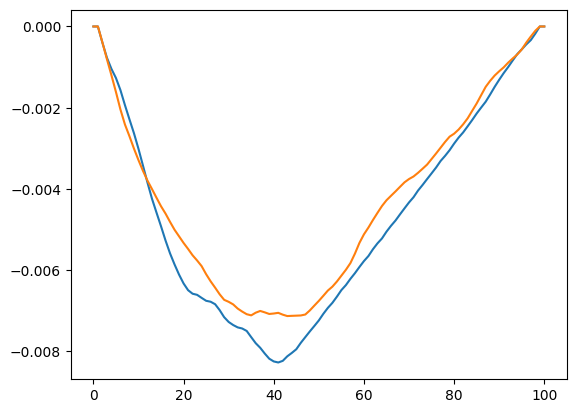

In [9]:
plt.plot(sol[500])
plt.plot(sol[20000])

Make an animation of the string: (1/dt is fps)

In [10]:
1/dt # = 200000

199999.99999999997

$$dt \text{ seconds}: 1 \text{ frame}$$
$$1 \text{ second} : x \text{ frames}$$
$$x = \frac{1}{dt}$$

So 200000 fps. Lets only index every 10 frames which gives 20000 fps. If we choose a gif fps of 20, this means our animation is moving 1000x slower than real life

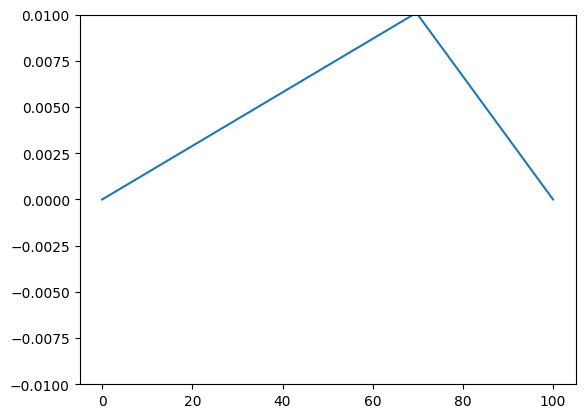

In [11]:
def animate(i):
    ax.clear()
    ax.plot(sol[i*10])
    ax.set_ylim(-0.01, 0.01)

fig, ax = plt.subplots(1, 1)
ax.set_ylim(-0.01, 0.01)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('string.gif', writer='pillow', fps=20)

# Create .wav file of noise

Extract the "amount" of harmonics at any time t:

$$\text{Amplitude of harmonic n at time } t \propto \int_{0}^{L} {y(x,t)sin\Big(\frac{n\pi x}{L})}dx$$

In [14]:
def get_integral(n):
    sin_arr = np.sin(n*np.pi*np.linspace(0, 1, 101))
    return np.array([sum(sin_arr*s) for s in sol])

In [15]:
hms = [get_integral(n) for n in range(10)]

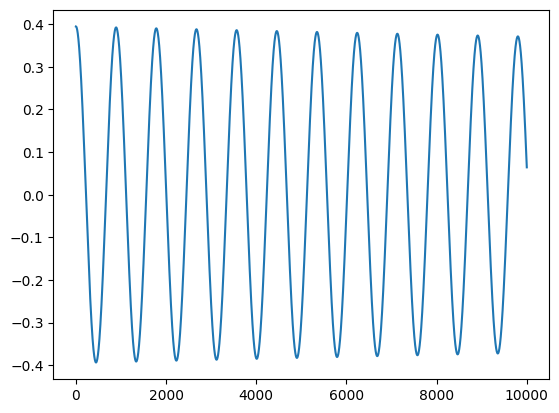

In [18]:
plt.plot(hms[1][0:10000])

Add them together

In [20]:
tot = sum(hms)[::10]
tot = tot.astype(np.float32)

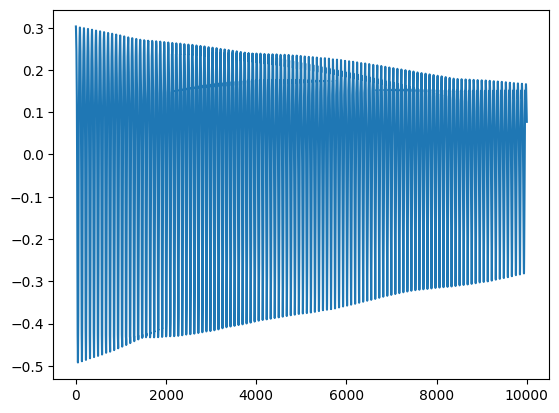

In [21]:
plt.plot(tot[0:10000])

Make wav file

In [24]:
wavfile.write('sound.wav', 20000, tot)

In [25]:
Audio('sound.wav')